In [1]:
import sys
sys.path.append("/Users/babis/GitHub/relAI-Github/relationalai-python-spcs/src")
import sys
sys.path.append(".")
!{sys.executable} -m pip install matplotlib > /dev/null 2>&1
import install_experimental_egonets
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import alias, aggregates, rel
from relationalai.experimental.pathfinder import path, find_paths
from relationalai.experimental.graphs import ego_network
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
model = rai.Model("TransferTokenDB") # this is the name of our database essentially

In [3]:
# install an experimental graph library that allows the user to zoom in the induced subgraph
import install_experimental_egonets
install_experimental_egonets.install_egonets_library(model)

 Checking currently installed libraries: 


[{'relationId': '/:output/String/String/String', 'table':                       v1                                    v2      v3
0               graphlib  04cd9c07-16aa-4433-bdd7-adfdfaee317d  0.1.50
1  graphlib_experimental  8ffe87bf-0f1a-658f-da9f-dd2296c55c50   0.1.0
2               rel_lang  4dd4b238-8c3f-eab2-0e15-dabd8bda3ef5   0.1.0
3                    std  24c1872c-de8a-5b12-7648-3d72f007a7a9  0.1.13}]

 Checking currently available libraries: 
[{'relationId': '/:output/(:std::pkg::Package,HashValue)/String', 'table':                                              v1                     v2
0   [10534968473600496114, 1129261748255661112]               graphlib
1    [2306880588977190036, 3165020205177183221]               rel_lang
2    [9062426728152259486, 5231004664590165377]                  rtest
3   [17047117323325327411, 8576148728512224055]  graphlib_experimental
4    [5771293398826273466, 8592401567927621940]                    std
5   [3177633211550935698, 104933872646016

In [4]:
token_dataset = model.Type("Data", source="TOKENTRANSFER.PUBLIC.DATA")
# ALTER TABLE TOKENTRANSFER.PUBLIC.DATA SET CHANGE_TRACKING = TRUE;

In [5]:
# create the graph as unweighted
Person = model.Type("Person")
Transfer = model.Type("TokenTransfer")

with model.rule():
    e = token_dataset()
    source = e.sender
    destination = e.receiver
    amount = e.amount
    p1 = Person.add(person_id = source)
    p2 = Person.add(person_id = destination)
    Transfer.add(sender = p1, receiver = p2).set(tokens = amount)

directed_graph = Graph(model, undirected = False)
Node = directed_graph.Node
Node.extend(Person, node_id = Person.person_id)


with model.rule():
    t = Transfer()
    directed_graph.Edge.add(t.sender, t.receiver)

In [6]:
with model.query() as select:
    p = directed_graph.Node()
    response = select(alias(p.node_id, "node_id"))

node_df = response.results

with model.query() as select:
    e = directed_graph.Edge()
    directed_edges = select(alias(Node(e.from_).node_id, "s"), alias(Node(e.to).node_id, "t"))

directed_edges_df = directed_edges.results

In [7]:
# basic statistics
# Get the number of nodes and edges in the digraph.
with model.query() as select:
    num_nodes = directed_graph.compute.num_nodes()
    num_edges = directed_graph.compute.num_edges()
    stats = select(alias(num_nodes, "#nodes"), alias(num_edges, "#edges"))

print(stats.results)


   #nodes  #edges
0    2764    7847


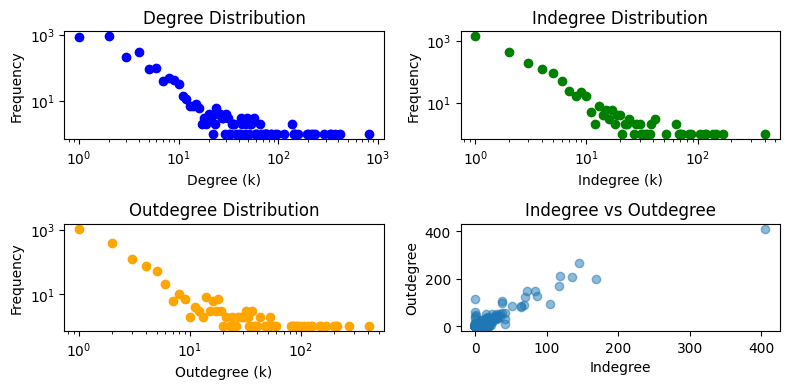

In [8]:
with model.query() as select:
    node = directed_graph.Node()
    degree = directed_graph.compute.degree(node)
    indegree = directed_graph.compute.indegree(node)
    outdegree = directed_graph.compute.outdegree(node)
    node.set(degree = degree)
    response = select(node.node_id,  alias(degree, "degree"), alias(indegree, "indegree"), alias(outdegree, "outdegree"))

directed_node_stats_df = response.results

# Filter to only non-zero for log-scale plots
nonzero_deg = directed_node_stats_df[directed_node_stats_df['degree'] > 0]
nonzero_indeg = directed_node_stats_df[directed_node_stats_df['indegree'] > 0]
nonzero_outdeg = directed_node_stats_df[directed_node_stats_df['outdegree'] > 0]

fig, axs = plt.subplots(2, 2, figsize=(8, 4))

# 1. Degree distribution
degree_counts = nonzero_deg['degree'].value_counts().sort_index()
axs[0, 0].scatter(degree_counts.index, degree_counts.values, color='blue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Degree Distribution')
axs[0, 0].set_xlabel('Degree (k)')
axs[0, 0].set_ylabel('Frequency')

# 2. Indegree distribution
indegree_counts = nonzero_indeg['indegree'].value_counts().sort_index()
axs[0, 1].scatter(indegree_counts.index, indegree_counts.values, color='green')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Indegree Distribution')
axs[0, 1].set_xlabel('Indegree (k)')
axs[0, 1].set_ylabel('Frequency')

# 3. Outdegree distribution
outdegree_counts = nonzero_outdeg['outdegree'].value_counts().sort_index()
axs[1, 0].scatter(outdegree_counts.index, outdegree_counts.values, color='orange')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Outdegree Distribution')
axs[1, 0].set_xlabel('Outdegree (k)')
axs[1, 0].set_ylabel('Frequency')

# 4. Indegree vs Outdegree scatter with annotations
axs[1, 1].scatter(directed_node_stats_df['indegree'], directed_node_stats_df['outdegree'], alpha=0.5)

axs[1, 1].set_xlabel('Indegree')
axs[1, 1].set_ylabel('Outdegree')
axs[1, 1].set_title('Indegree vs Outdegree')

plt.tight_layout()
plt.show()


In [9]:
# we can choose a subset of the nodes based on the degree
with model.query() as select:
    node = directed_graph.Node()
    degree = directed_graph.compute.degree(node)
    degree >= 4
    degree < 7
    filtered_response = select(alias(node.node_id, "node_id"),  alias(degree, "degree"))

filtered_df = filtered_response.results
filtered_df.head(12)

,node_id,degree
0,0x00c600b30fb0400701010f4b080409018b9006e0,5
1,0x010b6af33c8a6ef8d2c47d67ec2b213cbfb90c16,4
2,0x0176e73cf528c7b91b1500fcec380e67c17a5b71,5
3,0x01c37bd2a69c259efa96454889361cbf83937fcc,4
4,0x01d5bf76ddae666c720048cc88dde9fd030f4552,6
5,0x039f7c7e22c1c3bba5e871029ca72d5ddead295b,4
6,0x03d4e4a360f2886b5ab797cd3d61da331f77c710,4
7,0x03ec6374bee663c3dedb3de3df99750c6f51727c,5
8,0x0439008e5decb4c4d3099d6f050fb4aa774fec96,4
9,0x0596c3e687429ada8997a0b8f6ff98e1ddaf8ee1,4


In [10]:
with model.rule():
    p = directed_graph.Node()
    pagerank = directed_graph.compute.pagerank(p)
    p.set(pagerank = pagerank)
    directed_graph.Node(p).set(pagerank = pagerank)

with model.query() as select:
    p = directed_graph.Node()
    response = select(p.node_id, p.pagerank)

print(response.results.head(5))

with model.query() as select:
    p = directed_graph.Node()
    rank = aggregates.rank_desc(p.pagerank)
    response = select(rank, alias(p.node_id, "node_id"), p.pagerank)

print(response.results.head(5))


                                      node_id  pagerank
0  0x00000000009726632680fb29d3f7a9734e3010e2  0.000197
1  0x00000688768803bbd44095770895ad27ad6b0d95  0.000168
2  0x000006f35da787ce9310dfc45b95760045a3201a  0.000118
3  0x000010036c0190e009a000d0fc3541100a07380a  0.000593
4  0x002603c07c6e47cd33a2a5423e55ec141588a5dd  0.000199
   result                                     node_id  pagerank
0       1  0x57f25dd735ed502e46fb63af820297bf8409c703  0.074719
1       2  0xd84f296d2c7b3247bed49e951f62b5d17c8d2c14  0.022954
2       3  0x6bf7d6753756805ae812deaad440bc5e21fd27bd  0.019802
3       4  0xbbd6ca30184c1eab3b75b978fcafb171b5c7543f  0.019374
4       5  0x2acac41fe2a44e41c5cf9639367a9310e5c76999  0.012903


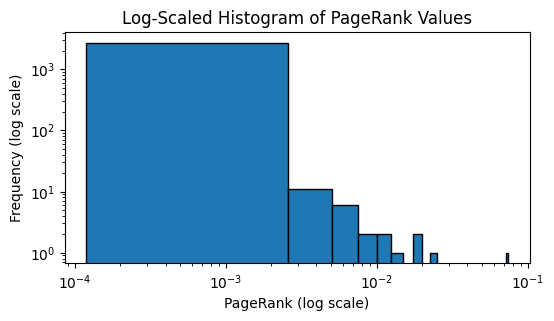

In [11]:
pagerank_df = response.results

# Avoid log(0) by filtering out zero or near-zero values
nonzero_pagerank = pagerank_df[pagerank_df['pagerank'] > 0]['pagerank']
plt.figure(figsize=(6, 3))
plt.hist(nonzero_pagerank, bins=30, edgecolor='black', log=True)
plt.xscale('log')
plt.title('Log-Scaled Histogram of PageRank Values')
plt.xlabel('PageRank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


In [13]:
# let's show the 1-hop network of the most central node according to PR
from relationalai.experimental.graphs import ego_network

with model.query() as select:
    node = directed_graph.Node()
    node.node_id == '0x57f25dd735ed502e46fb63af820297bf8409c703'
    a,b = ego_network(directed_graph, node, 1)
    ego_response = select(alias(node.node_id,"ego_node id"), alias(directed_graph.Node(a).node_id, "u"), alias(directed_graph.Node(b).node_id, "v"))

print(ego_response.results.head(3))

                                  ego_node id  \
0  0x57f25dd735ed502e46fb63af820297bf8409c703   
1  0x57f25dd735ed502e46fb63af820297bf8409c703   
2  0x57f25dd735ed502e46fb63af820297bf8409c703   

                                            u  \
0  0x0162ccbe8961b9e33c788c463f4c9428333b2d6f   
1  0x01a410ec09e4f2026c2148eca8e7e106a3820177   
2  0x01b67600a531f2b0a6c93827d8dd2e9bd9a4983b   

                                            v  
0  0x57f25dd735ed502e46fb63af820297bf8409c703  
1  0x57f25dd735ed502e46fb63af820297bf8409c703  
2  0x57f25dd735ed502e46fb63af820297bf8409c703  


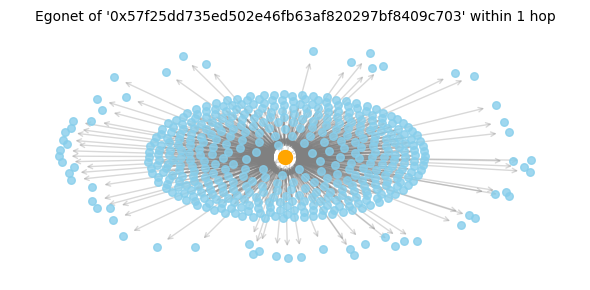

In [16]:
def visualize_ego_network(ego_df, target_node, hops=2):
    """
    Visualizes the ego network of a target node within a specified number of hops.

    Parameters:
    - ego_df (pd.DataFrame): DataFrame with columns ['v', 'v2'] representing directed edges.
    - target_node (str): The node to center the egonet on.
    - hops (int): The number of hops from the target node to include in the egonet.
    """
    ego_subgraph = nx.DiGraph()
    for _, row in ego_df.iterrows():
        ego_subgraph.add_edge(row['u'], row['v'])

    pos = nx.spring_layout(ego_subgraph, seed=42, k=0.25)
    plt.figure(figsize=(6, 3))

    nx.draw_networkx_nodes(
        ego_subgraph, pos,
        nodelist=[n for n in ego_subgraph.nodes if n != target_node],
        node_size=30,
        node_color='skyblue',
        alpha=0.8
    )

    nx.draw_networkx_nodes(
        ego_subgraph, pos,
        nodelist=[target_node],
        node_size=100,
        node_color='orange',
        alpha=1.0
    )
    nx.draw_networkx_edges(
        ego_subgraph, pos,
        arrowstyle='->',
        arrowsize=8,
        edge_color='gray',
        alpha=0.3
    )

    plt.title(f"Egonet of '{target_node}' within {hops} hop{'s' if hops > 1 else ''}", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


visualize_ego_network(ego_response.results, '0x57f25dd735ed502e46fb63af820297bf8409c703', hops=1)

# Anomaly detection using Benford's law

In [17]:
# Benford's expected distribution for digits 1 through 9
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])

def first_digit(x):
    x = abs(x)
    while x >= 10:
        x //= 10
    while 0 < x < 1:
        x *= 10
    return int(x) if x >= 1 else None


def chi_squared(observed, expected):
    return np.sum((observed - expected) ** 2 / expected)


We need to create a weighted directed graph this time, since the weights of the transactions will be important for this task. Specifically, we will partition the graph into communities using Infomap and then we will compute for each (large enough) community its anomaly score.

In [18]:
weighted_directed_graph = Graph(model, undirected = False, weighted=True)
Node = weighted_directed_graph.Node
Node.extend(Person, node_id = Person.person_id)

with model.rule():
    t = Transfer()
    weighted_directed_graph.Edge.add(t.sender, t.receiver, weight = t.tokens)

We use the weighted version of the graph to find the communities.

In [20]:
# Find the community label for each person in the graph.
with model.query() as select:
    node = weighted_directed_graph.Node()
    community = weighted_directed_graph.compute.infomap(node)
    node.set(community = community)
    infomap_response = select(alias(node.node_id,"node"), alias(community, "community_label"))

infomap_df = infomap_response.results
infomap_df.head(5)

,node,community_label
0,0x00000000009726632680fb29d3f7a9734e3010e2,129
1,0x00000688768803bbd44095770895ad27ad6b0d95,112
2,0x000006f35da787ce9310dfc45b95760045a3201a,100
3,0x000010036c0190e009a000d0fc3541100a07380a,382
4,0x002603c07c6e47cd33a2a5423e55ec141588a5dd,16


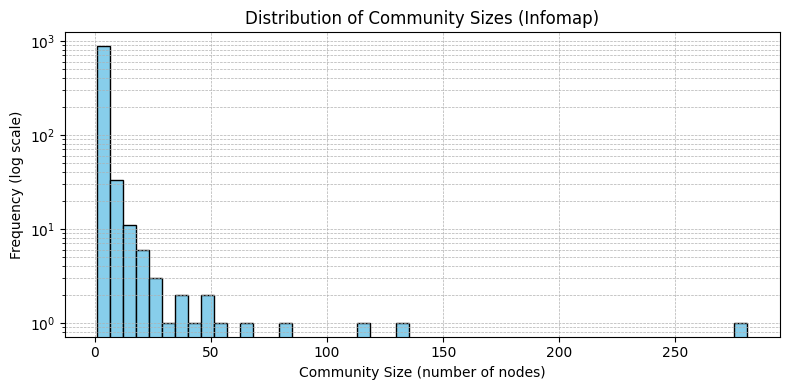

In [21]:
community_sizes = infomap_df['community_label'].value_counts()

plt.figure(figsize=(8, 4))
plt.hist(community_sizes, bins=50, color='skyblue', edgecolor='black', log=True)

plt.xlabel("Community Size (number of nodes)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Community Sizes (Infomap)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [22]:


# let's see the community ids and sizes of the top 10 communities
print(infomap_df.value_counts('community_label').sort_values(ascending=False).head(10))



community_label
10    281
8     132
14    118
4      83
70     68
30     56
21     51
19     48
55     42
1      40
Name: count, dtype: int64


In [24]:
with model.query() as select:
    e = weighted_directed_graph.Edge()
    n1 = e.from_
    n2 = e.to
    community1 = weighted_directed_graph.compute.infomap(n1)
    community2 = weighted_directed_graph.compute.infomap(n2)
    community1 == community2
    largest_infomap_community = select( alias(n1, 's'),   alias(n2, 't'), alias(e.weight, 'weight'), alias(community1,'community_label'))

induced_community_subgraphs = largest_infomap_community.results
induced_community_subgraphs.head(5)

def visualize_community(df, community_id,message=""):
    """
    Visualizes a directed graph of a specific community in the given DataFrame.

    Parameters:
    - df: pandas DataFrame with columns ['s', 't', 'community_label']
    - community_id: int or str, the ID of the community to visualize
    """
    # Filter for the requested community
    community_df = df[df['community_label'] == community_id]

    if community_df.empty:
        print(f"Community ID {community_id} not found in the DataFrame.")
        return

    # Create the directed graph
    DG = nx.DiGraph()
    for _, row in community_df.iterrows():
        DG.add_edge(row['s'], row['t'])

    # Visualize
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(DG, seed=42)

    nx.draw_networkx_nodes(DG, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(DG, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
    # nx.draw_networkx_labels(DG, pos, font_size=6)  # Optional

    plt.title(f"Visualization of Infomap Community {community_id}"+message)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


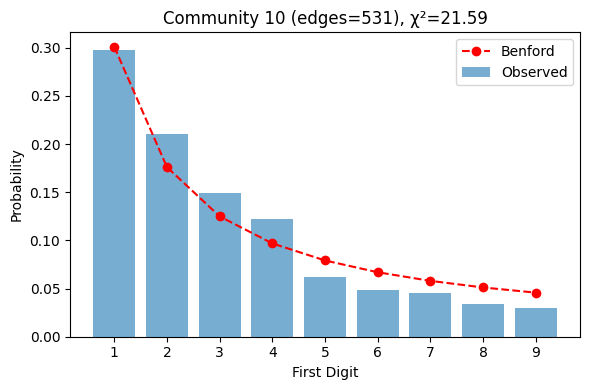

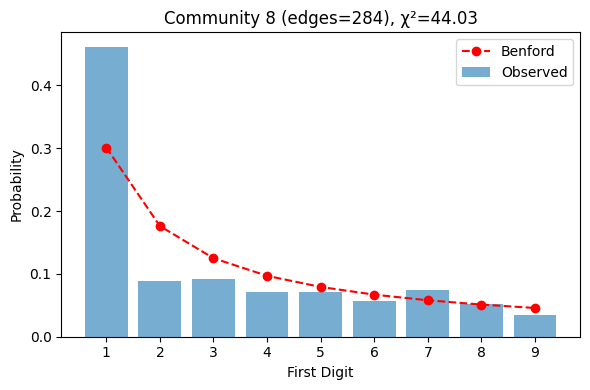

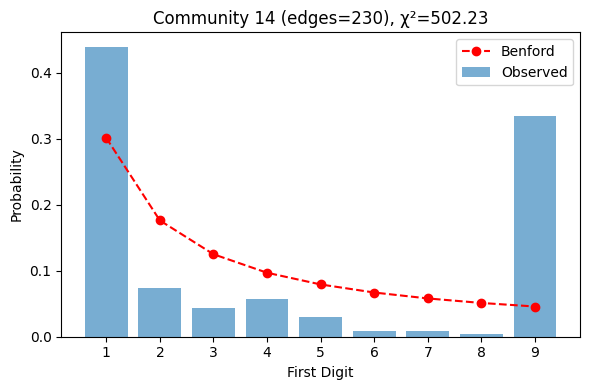

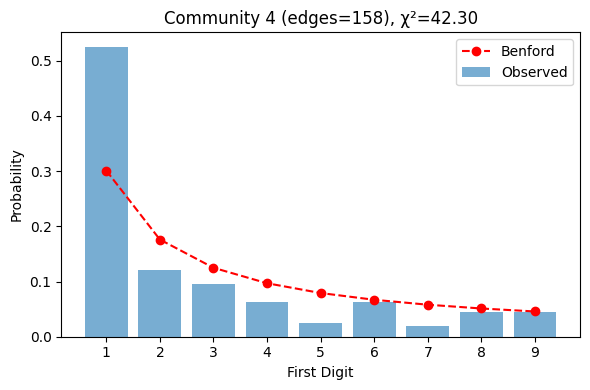

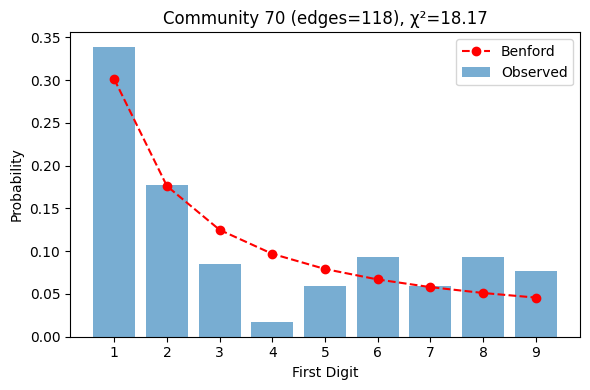

Community with highest chi-squared score: 14 (χ²=502.23)


In [25]:

# Ensure weight column is numeric
induced_community_subgraphs['weight'] = pd.to_numeric(induced_community_subgraphs['weight'], errors='coerce')

# Group by community and compute edge counts
grouped = induced_community_subgraphs.groupby('community_label')
community_sizes = grouped.size().sort_values(ascending=False)

# Select top 5 communities by edge count
top_communities = community_sizes.head(5).index

chi_scores = {}

# Analyze and plot each top community
for label in top_communities:
    group = grouped.get_group(label)
    weights = group['weight'].dropna()
    first_digits = weights.apply(first_digit).dropna().astype(int)

    digit_counts = first_digits.value_counts().reindex(range(1, 10), fill_value=0)
    total = digit_counts.sum()
    if total == 0:
        continue

    digit_probs = digit_counts / total
    expected_counts = benford_probs * total
    observed_counts = digit_counts.values

    # Manual chi-squared statistic
    chi_stat = chi_squared(observed_counts, expected_counts)
    chi_scores[label] = chi_stat

    # Plot observed vs Benford
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, 10), digit_probs, alpha=0.6, label='Observed')
    plt.plot(range(1, 10), benford_probs, 'r--', marker='o', label='Benford')
    plt.xticks(range(1, 10))
    plt.xlabel("First Digit")
    plt.ylabel("Probability")
    plt.title(f"Community {label} (edges={len(weights)}), χ²={chi_stat:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Print the community with the highest chi-squared score
if chi_scores:
    most_anomalous = max(chi_scores, key=chi_scores.get)
    print(f"Community with highest chi-squared score: {most_anomalous} (χ²={chi_scores[most_anomalous]:.2f})")
else:
    print("No valid communities for chi-squared computation.")


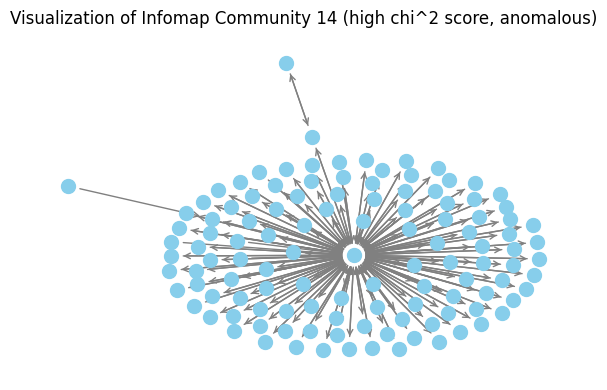

In [30]:


visualize_community(induced_community_subgraphs, 14," (high chi^2 score, anomalous)") #most anomalous


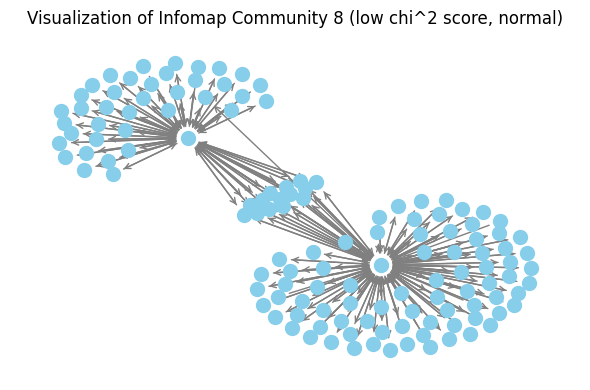

In [31]:

# some interesting structure with two central nodes and many intermediate nodes
visualize_community(induced_community_subgraphs, 8," (low chi^2 score, normal)") 